# QC overview — final_analysis_dataset

Quick checks to validate inputs before deeper analysis.

Key notions:
- Postings-weighted: `srvy_wght_tru1`
- Demand-weighted (headcount): `srvy_wght_tru2`
- Strict adoption: `ai_requirement == "True"`
- Lenient adoption: `ai_requirement in {"True","Maybe"}`


In [55]:
from pathlib import Path
import pandas as pd

# Robust root finder
def find_root():
    if "__file__" in globals():
        return Path(__file__).resolve().parents[2]
    cwd = Path.cwd().resolve()
    for p in [cwd] + list(cwd.parents):
        candidate = p / "Results Datasets" / "final_analysis_dataset.parquet"
        if candidate.exists():
            return p
    return cwd

ROOT = find_root()
DATA_PATH = ROOT / "Results Datasets" / "final_analysis_dataset.parquet"
print(f"Loading {DATA_PATH}")

df = pd.read_parquet(DATA_PATH)
# Filter window
df = df[(df["adve_time_year"] >= 2010) & (df["adve_time_year"] <= 2024)].copy()

df["adve_time_year"] = df["adve_time_year"].astype("int64")
df["ai_requirement"] = df["ai_requirement"].astype("string")

print(df.shape)
print(df.head())


Loading /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/final_analysis_dataset.parquet
(59794, 97)
                               adve_iden_sjob  \
0  sjmm_suf-1-01-2010-03-01118-0-000000001-01   
1  sjmm_suf-1-01-2010-03-01118-0-000000002-01   
2  sjmm_suf-1-01-2010-03-01119-0-000000001-01   
3  sjmm_suf-1-01-2010-03-01120-0-000000001-01   
4  sjmm_suf-1-01-2010-03-01120-0-000000002-01   

                            adve_iden_adve  adve_lang_lang  adve_chan_gene  \
0  sjmm_suf-1-01-2010-03-01118-0-000000001               0               1   
1  sjmm_suf-1-01-2010-03-01118-0-000000002               0               1   
2  sjmm_suf-1-01-2010-03-01119-0-000000001               0               1   
3  sjmm_suf-1-01-2010-03-01120-0-000000001               0               1   
4  sjmm_suf-1-01-2010-03-01120-0-000000002               0               1   

   adve_chan_type  adve_jobn_numb  adve_empl_nraw  adve_empl_nrec  \
0               1               1               1     

In [56]:
# Basic sanity prints
print("Year range:", df["adve_time_year"].min(), df["adve_time_year"].max())
print("ai_requirement counts:", df["ai_requirement"].value_counts(dropna=False))
print("Weights missing (tru1/tru2):", df["srvy_wght_tru1"].isna().sum(), df["srvy_wght_tru2"].isna().sum())


Year range: 2010 2024
ai_requirement counts: ai_requirement
False    56352
Maybe     2961
True       426
<NA>        55
Name: count, dtype: Int64
Weights missing (tru1/tru2): 0 0


## Missingness snapshot (key fields)
Columns inspected: ai labels, exposures, weights, education/skills/responsibility (clean), regions.

In [57]:
key_cols = [
    "ai_requirement",
    "occupation_exposure",
    "industry_exposure_weighted",
    "srvy_wght_tru1",
    "srvy_wght_tru2",
    # responsibility / skills / education clean fields
    "vaca_posi_mana_clean", "vaca_posi_resp_clean",
    "incu_expe_gene_clean", "incu_trai_gene_clean", "incu_skil_gene_clean",
    "incu_educ_ide1_clean", "incu_educ_ide2_clean",
    "incu_educ_typ1_clean", "incu_educ_typ2_clean",
    "incu_educ_yrs1_clean", "incu_educ_yrs2_clean", "incu_educ_yrsm_clean",
    # regions
    "loca_regi_kant", "loca_regi_nuts",
]

rows = []
for c in key_cols:
    if c not in df.columns:
        rows.append({"column": c, "dtype": "MISSING", "missing": len(df), "missing_pct": 100.0})
        continue
    miss = df[c].isna().sum()
    rows.append({
        "column": c,
        "dtype": str(df[c].dtype),
        "missing": miss,
        "missing_pct": miss / len(df) * 100,
    })
miss_tbl = pd.DataFrame(rows).sort_values("missing_pct", ascending=False)
miss_tbl


,column,dtype,missing,missing_pct
15,incu_educ_yrs2_clean,float64,47050,78.686825
13,incu_educ_typ2_clean,float64,47050,78.686825
14,incu_educ_yrs1_clean,float64,10464,17.500084
12,incu_educ_typ1_clean,float64,10464,17.500084
2,industry_exposure_weighted,Float64,9624,16.095260
1,occupation_exposure,Float64,5051,8.447336
16,incu_educ_yrsm_clean,float64,4424,7.398736
10,incu_educ_ide1_clean,Int64,4416,7.385356
11,incu_educ_ide2_clean,Int64,3786,6.331739
9,incu_skil_gene_clean,Int64,468,0.782687


In [58]:
# Special-code share (region unknown) using clean fields if present
special_codes = {-3, -7, -8, -9}
region_cols = [
    ("loca_regi_kant", "loca_regi_kant_clean"),
    ("loca_regi_nuts", "loca_regi_nuts_clean"),
]
rows = []
for raw_col, clean_col in region_cols:
    if raw_col not in df.columns:
        continue
    # raw counts for special codes
    raw_series = pd.to_numeric(df[raw_col], errors="coerce")
    special_mask = raw_series.isin(special_codes)
    rows.append({
        "column": raw_col,
        "unknown_count": int(special_mask.sum()),
        "unknown_pct": float(special_mask.mean()*100),
        "unknown_tru2_share": float(df.loc[special_mask, "srvy_wght_tru2"].sum() / df["srvy_wght_tru2"].sum()),
    })
    if clean_col in df.columns:
        rows[-1]["clean_used"] = True
    else:
        rows[-1]["clean_used"] = False
region_unknown = pd.DataFrame(rows)
region_unknown


,column,unknown_count,unknown_pct,unknown_tru2_share,clean_used
0,loca_regi_kant,3380,5.652741,0.060835,True
1,loca_regi_nuts,3380,5.652741,0.060835,True


In [59]:
# Duplicate checks
for col in ["adve_iden_sjob", "adve_iden_adve"]:
    if col in df.columns:
        dup = df[col].duplicated().sum()
        print(f"{col}: duplicates = {dup}")
        if dup:
            top_dup = df[df[col].duplicated(keep=False)][col].value_counts().head(5)
            print("Top duplicated IDs:", top_dup)


adve_iden_sjob: duplicates = 0
adve_iden_adve: duplicates = 2461
Top duplicated IDs: adve_iden_adve
sjmm_suf-3-01-2019-03-09003-1-024017706    10
sjmm_suf-1-01-2011-03-02213-0-000000001    10
sjmm_suf-1-01-2011-03-06206-0-000000010    10
sjmm_suf-1-01-2013-03-04119-0-000000004    10
sjmm_suf-1-01-2013-03-04122-0-000000009    10
Name: count, dtype: Int64


In [60]:
# Weight profiling
import numpy as np

for wcol in ["srvy_wght_tru1", "srvy_wght_tru2"]:
    if wcol not in df.columns:
        continue
    w = df[wcol]
    q = w.quantile([0.5, 0.9, 0.95, 0.99])
    print(f"\n{wcol} quantiles:")
    print(q)
    print(f"max: {w.max()}")

# Top-k share of tru2
w2 = df["srvy_wght_tru2"].sort_values(ascending=False)
total2 = w2.sum()
for k in [1, 5, 10]:
    share = w2.head(k).sum() / total2
    print(f"Top {k} ads share of total tru2: {share:.6f}")

# adve_empl_nrec vs tru2/tru1 ratio
if "adve_empl_nrec" in df.columns:
    ratio = df["srvy_wght_tru2"] / df["srvy_wght_tru1"]
    print("\ntru2/tru1 ratio describe:")
    print(ratio.describe())
    print("adve_empl_nrec describe:")
    print(df["adve_empl_nrec"].describe())



srvy_wght_tru1 quantiles:
0.50       16.2857
0.90          43.8
0.95       71.7875
0.99    215.662045
Name: srvy_wght_tru1, dtype: Float64
max: 430.0

srvy_wght_tru2 quantiles:
0.50      16.78145
0.90       47.7698
0.95       83.9867
0.99    290.674785
Name: srvy_wght_tru2, dtype: Float64
max: 380.0
Top 1 ads share of total tru2: 0.000232
Top 5 ads share of total tru2: 0.001160
Top 10 ads share of total tru2: 0.002320

tru2/tru1 ratio describe:
count      59794.0
mean      1.130781
std       0.980063
min       0.304114
25%            1.0
50%            1.0
75%            1.0
max      20.001138
dtype: Float64
adve_empl_nrec describe:
count     59794.0
mean     1.098639
std      0.620294
min           1.0
25%           1.0
50%           1.0
75%           1.0
max          20.0
Name: adve_empl_nrec, dtype: Float64


In [61]:
# Exposure missingness by year (unweighted and weighted)
exp_cols = ["occupation_exposure", "industry_exposure_weighted"]
rows = []
for year, g in df.groupby("adve_time_year"):
    row = {"year": int(year)}
    total_w = g["srvy_wght_tru2"].sum()
    for col in exp_cols:
        miss = g[col].isna()
        row[f"{col}_miss_pct"] = miss.mean() * 100
        row[f"{col}_miss_tru2_share"] = g.loc[miss, "srvy_wght_tru2"].sum() / total_w if total_w > 0 else 0
    rows.append(row)
exp_missing_by_year = pd.DataFrame(rows).sort_values("year")
exp_missing_by_year


,year,occupation_exposure_miss_pct,occupation_exposure_miss_tru2_share,industry_exposure_weighted_miss_pct,industry_exposure_weighted_miss_tru2_share
0,2010,6.266830,0.058251,20.171359,0.153547
1,2011,7.216004,0.055885,17.623244,0.148957
2,2012,8.492120,0.092880,14.231945,0.114610
3,2013,8.750000,0.088287,15.000000,0.131913
4,2014,9.344529,0.085730,15.763814,0.148622
5,2015,8.722657,0.086953,16.149068,0.142223
6,2016,8.189655,0.075305,16.531440,0.139689
7,2017,7.755521,0.074310,16.409861,0.144115
8,2018,6.188119,0.060805,15.148515,0.135761
9,2019,7.611356,0.069269,16.054821,0.122244


## Grouping coverage (counts & missing)
Quick look at availability of groupers (ISCO, NOGA, canton/NUTS).

In [62]:
group_cols = {
    "occu_isco_2008": "ISCO-08 (unit)",
    "occu_isco_ch19": "CH-ISCO-19",
    "comp_indu_noga": "NOGA",
    "loca_regi_kant": "Canton",
    "loca_regi_nuts": "NUTS-2",
}

for col, label in group_cols.items():
    if col not in df.columns:
        print(f"{label} ({col}) missing in dataset")
        continue
    miss = df[col].isna().sum()
    distinct = df[col].nunique(dropna=True)
    print(f"\n{label} ({col}) -> distinct={distinct}, missing={miss}")
    top = df[col].value_counts(dropna=True).head(10)
    top_w = df.groupby(col)["srvy_wght_tru1"].sum().sort_values(ascending=False).head(10)
    display(top)
    display(top_w)



ISCO-08 (unit) (occu_isco_2008) -> distinct=437, missing=0


occu_isco_2008
5223    2349
2221    2293
4110    2216
2512    1667
4419    1400
3112    1033
5131    1015
1221     945
2431     919
3313     806
Name: count, dtype: Int64

occu_isco_2008
5223    74641.7897
4110    51161.9399
2512    49468.7148
2221     49409.008
4419    33775.3562
5131    32364.4217
3118    29705.4185
3112    29451.1366
1221    25735.9162
2511    21883.8628
Name: srvy_wght_tru1, dtype: Float64


CH-ISCO-19 (occu_isco_ch19) -> distinct=494, missing=0


occu_isco_ch19
52230    2349
41100    2216
22212    1690
44192    1166
24310     919
25121     899
33130     806
51200     793
72001     769
12211     752
Name: count, dtype: Int64

occu_isco_ch19
52230    74641.7897
41100    51161.9399
22212    37315.3286
44192    27457.7492
25121    26810.4776
12211    21636.9397
24310    21054.6045
51200    20781.8855
31121    19765.5856
72330    19194.7046
Name: srvy_wght_tru1, dtype: Float64


NOGA (comp_indu_noga) -> distinct=51, missing=0


comp_indu_noga
44    6265
24    4471
21    3237
42    2983
43    2925
39    2751
33    2527
15    2057
32    1893
30    1864
Name: count, dtype: Int64

comp_indu_noga
24    132005.0777
44    127600.7458
39    112374.8064
21     85354.4148
23     62220.1317
43     62208.8672
32     59590.8619
51     53787.4865
33     53028.7561
30     49205.8672
Name: srvy_wght_tru1, dtype: Float64


Canton (loca_regi_kant) -> distinct=27, missing=0


loca_regi_kant
1     14532
2      8040
19     3939
17     3552
22     3519
-3     3380
25     2713
12     2710
3      2634
11     1811
Name: count, dtype: Int64

loca_regi_kant
1      379496.352
2     202813.5941
19    107260.5413
17     97995.3784
-3     82244.3879
22     78486.2606
12     75645.2685
3      71584.2586
11     58998.7676
25     52345.4166
Name: srvy_wght_tru1, dtype: Float64


NUTS-2 (loca_regi_nuts) -> distinct=8, missing=0


loca_regi_nuts
4     14532
2     12285
3      8096
1      7935
5      7538
6      5029
-3     3380
7       999
Name: count, dtype: Int64

loca_regi_nuts
4      379496.352
2     312610.1028
3     223039.4738
5     205081.1462
1     163287.9454
6     138016.4154
-3     82244.3879
7      13510.9022
Name: srvy_wght_tru1, dtype: Float64

In [63]:
# AI label summary table
ai_label_summary = (
    df.assign(lenient=df["ai_requirement"].isin(["True","Maybe"]))
      .groupby("ai_requirement")
      .agg(
          count=("ai_requirement","size"),
          post_w=("srvy_wght_tru1","sum"),
          dem_w=("srvy_wght_tru2","sum"),
      )
      .reset_index()
)
# overall totals for shares
all_tot = df[["srvy_wght_tru1","srvy_wght_tru2"]].sum()
ai_label_summary["post_share"] = ai_label_summary["post_w"] / all_tot["srvy_wght_tru1"]
ai_label_summary["dem_share"] = ai_label_summary["dem_w"] / all_tot["srvy_wght_tru2"]
ai_label_summary


,ai_requirement,count,post_w,dem_w,post_share,dem_share
0,False,56352,1430544.8486,1547357.0835,0.942831,0.944578
1,Maybe,2961,76504.5812,79560.5791,0.050422,0.048567
2,True,426,8804.8578,9719.1328,0.005803,0.005933


In [64]:
# Weight profile table
import numpy as np
weight_rows = []
for wcol in ["srvy_wght_tru1", "srvy_wght_tru2"]:
    if wcol not in df.columns:
        continue
    w = df[wcol]
    qs = w.quantile([0.5,0.9,0.95,0.99])
    weight_rows.append({"metric":"p50", wcol: qs.loc[0.5]})
    weight_rows.append({"metric":"p90", wcol: qs.loc[0.9]})
    weight_rows.append({"metric":"p95", wcol: qs.loc[0.95]})
    weight_rows.append({"metric":"p99", wcol: qs.loc[0.99]})
    weight_rows.append({"metric":"max", wcol: w.max()})
weight_profile = pd.DataFrame(weight_rows).groupby("metric").first().reset_index()

# Top-k shares for tru2
if "srvy_wght_tru2" in df.columns:
    w2 = df["srvy_wght_tru2"].sort_values(ascending=False)
    total2 = w2.sum()
    top_shares = {
        "metric": ["top1_share", "top5_share", "top10_share"],
        "srvy_wght_tru2": [w2.head(k).sum()/total2 for k in [1,5,10]],
    }
    weight_profile = pd.concat([weight_profile, pd.DataFrame(top_shares)], ignore_index=True)

weight_profile


,metric,srvy_wght_tru1,srvy_wght_tru2
0,max,430.000000,380.000000
1,p50,16.285700,16.781450
2,p90,43.800000,47.769800
3,p95,71.787500,83.986700
4,p99,215.662045,290.674785
5,top1_share,NaN,0.000232
6,top5_share,NaN,0.001160
7,top10_share,NaN,0.002320


In [65]:
# Duplicate summary table
dup_rows = []
for col in ["adve_iden_sjob", "adve_iden_adve"]:
    if col in df.columns:
        dup_rows.append({"column": col, "duplicates": int(df[col].duplicated().sum())})
duplicates_summary = pd.DataFrame(dup_rows)
duplicates_summary


,column,duplicates
0,adve_iden_sjob,0
1,adve_iden_adve,2461


## Exposure quick sanity
Unweighted and tru2-weighted summaries for occupational and industry exposure.

In [66]:
import numpy as np

def weighted_stats(series, weights):
    s = series.to_numpy()
    w = weights.to_numpy()
    m = np.average(s, weights=w)
    # weighted quantiles via cumulative weights
    order = np.argsort(s)
    s_sorted = s[order]
    w_sorted = w[order]
    cum_w = np.cumsum(w_sorted)
    total = cum_w[-1]
    def wq(p):
        return s_sorted[np.searchsorted(cum_w, p * total)]
    return {
        "w_mean": m,
        "w_p10": wq(0.10),
        "w_p50": wq(0.50),
        "w_p90": wq(0.90),
    }

for col in ["occupation_exposure", "industry_exposure_weighted"]:
    if col not in df.columns:
        print(f"Missing {col}")
        continue
    s = df[col].dropna()
    print(f"\n{col} unweighted:")
    print(s.describe())
    # weighted by tru2
    mask = df[col].notna()
    stats_w = weighted_stats(df.loc[mask, col], df.loc[mask, "srvy_wght_tru2"])
    print(f"{col} weighted (tru2): {stats_w}")



occupation_exposure unweighted:
count     54743.0
mean     0.374782
std      0.882224
min     -2.122764
25%     -0.262804
50%      0.526379
75%      1.186602
max      1.446232
Name: occupation_exposure, dtype: Float64
occupation_exposure weighted (tru2): {'w_mean': 0.29395403059363767, 'w_p10': -1.0474146222222225, 'w_p50': 0.4360305666666666, 'w_p90': 1.277449425}

industry_exposure_weighted unweighted:
count     50170.0
mean    -0.569584
std      0.460081
min     -1.962105
25%     -0.904773
50%     -0.645291
75%      -0.13216
max      0.790156
Name: industry_exposure_weighted, dtype: Float64
industry_exposure_weighted weighted (tru2): {'w_mean': -0.544685364431153, 'w_p10': -0.9639388290322581, 'w_p50': -0.6452913347826088, 'w_p90': 0.12862043333333334}


## AI label snapshot (strict & lenient)
Counts and weighted totals for strict (True) and lenient (True+Maybe).

In [67]:
label_counts = df["ai_requirement"].value_counts(dropna=False)
print(label_counts)

summary = (
    df.assign(lenient=df["ai_requirement"].isin(["True","Maybe"]))
      .groupby("ai_requirement")
      .agg(post_w=("srvy_wght_tru1", "sum"), dem_w=("srvy_wght_tru2", "sum"))
)
print("\nWeighted by label:\n", summary)

strict = df[df["ai_requirement"] == "True"]
lenient = df[df["ai_requirement"].isin(["True","Maybe"])].copy()

strict_tot = strict[["srvy_wght_tru1","srvy_wght_tru2"]].sum()
lenient_tot = lenient[["srvy_wght_tru1","srvy_wght_tru2"]].sum()
all_tot = df[["srvy_wght_tru1","srvy_wght_tru2"]].sum()

print("\nShares (weighted):")
print("Strict postings share:", strict_tot["srvy_wght_tru1"] / all_tot["srvy_wght_tru1"])
print("Strict demand share:", strict_tot["srvy_wght_tru2"] / all_tot["srvy_wght_tru2"])
print("Lenient postings share:", lenient_tot["srvy_wght_tru1"] / all_tot["srvy_wght_tru1"])
print("Lenient demand share:", lenient_tot["srvy_wght_tru2"] / all_tot["srvy_wght_tru2"])


ai_requirement
False    56352
Maybe     2961
True       426
<NA>        55
Name: count, dtype: Int64

Weighted by label:
                       post_w         dem_w
ai_requirement                            
False           1430544.8486  1547357.0835
Maybe             76504.5812    79560.5791
True               8804.8578     9719.1328

Shares (weighted):
Strict postings share: 0.0058030282944299015
Strict demand share: 0.005933004611537612
Lenient postings share: 0.05622499528600471
Lenient demand share: 0.054500432633192264


## Yearly coverage
Unweighted counts and weighted totals by year (postings and demand).

In [68]:
yearly = df.groupby("adve_time_year").agg(
    postings_unw=("adve_time_year","size"),
    postings_w=("srvy_wght_tru1","sum"),
    demand_w=("srvy_wght_tru2","sum"),
).reset_index().rename(columns={"adve_time_year":"year"})
print(yearly)


    year  postings_unw   postings_w     demand_w
0   2010          4085   72730.7017   80201.1171
1   2011          4199   91055.1722   96098.3044
2   2012          4251   92425.5602  101527.7178
3   2013          4320   94492.2162  102255.5986
4   2014          3692  100227.6535  107862.6531
5   2015          3703   95716.8056  102542.0088
6   2016          3944   98204.9033   104038.788
7   2017          3894    99701.576  107467.6759
8   2018          4040  104677.2332  113359.3204
9   2019          4086   96636.5573  105048.6306
10  2020          3918  104206.8669  105065.0702
11  2021          4003   82419.4839   84080.8777
12  2022          3966  124719.8247  133237.5833
13  2023          3712  132839.1517  140083.1894
14  2024          3981  127233.0193  155278.3121


## Save QC tables
- missingness table
- yearly coverage table


In [69]:
OUT_DIR = ROOT / "Results Datasets" / "analysis" / "phase0_qc"
OUT_DIR_TABLES = OUT_DIR / "tables"
OUT_DIR_VIS = OUT_DIR / "visuals"
for d in [OUT_DIR, OUT_DIR_TABLES, OUT_DIR_VIS]:
    d.mkdir(parents=True, exist_ok=True)

miss_tbl.to_csv(OUT_DIR_TABLES / "qc_missingness.csv", index=False)
yearly.to_csv(OUT_DIR_TABLES / "qc_yearly_coverage.csv", index=False)
if 'region_unknown' in globals():
    region_unknown.to_csv(OUT_DIR_TABLES / "qc_region_unknown.csv", index=False)
if 'exp_missing_by_year' in globals():
    exp_missing_by_year.to_csv(OUT_DIR_TABLES / "qc_exposure_missing_by_year.csv", index=False)
if 'ai_label_summary' in globals():
    ai_label_summary.to_csv(OUT_DIR_TABLES / "qc_ai_labels.csv", index=False)
if 'weight_profile' in globals():
    weight_profile.to_csv(OUT_DIR_TABLES / "qc_weight_profile.csv", index=False)
if 'duplicates_summary' in globals():
    duplicates_summary.to_csv(OUT_DIR_TABLES / "qc_duplicates.csv", index=False)
print("Saved tables to", OUT_DIR_TABLES)


Saved tables to /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase0_qc/tables


## Notes
Use this QC as the staging point: if anything looks odd (missingness spikes, weight gaps), resolve before deeper analyses.

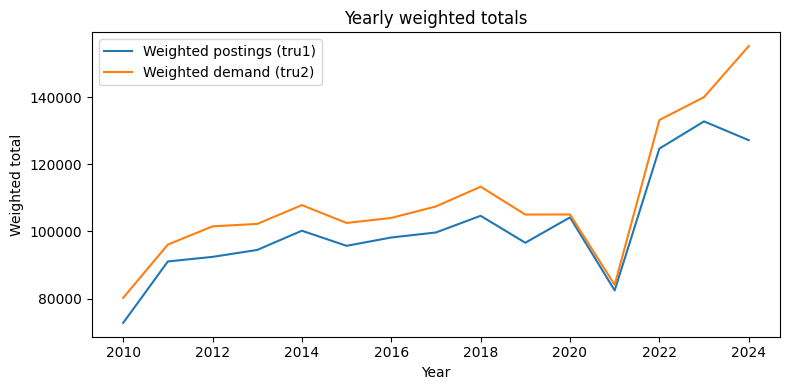

Saved plot to /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase0_qc/visuals/yearly_weighted_totals.png


In [70]:
# Yearly weighted totals: postings (tru1) vs demanded people (tru2)
import matplotlib.pyplot as plt
OUT_DIR = ROOT / "Results Datasets" / "analysis" / "phase0_qc"
OUT_DIR_TABLES = OUT_DIR / "tables"
OUT_DIR_VIS = OUT_DIR / "visuals"
for d in [OUT_DIR, OUT_DIR_TABLES, OUT_DIR_VIS]:
    d.mkdir(parents=True, exist_ok=True)

plt.figure(figsize=(8,4))
plt.plot(yearly['year'], yearly['postings_w'], label='Weighted postings (tru1)')
plt.plot(yearly['year'], yearly['demand_w'], label='Weighted demand (tru2)')
plt.title('Yearly weighted totals')
plt.xlabel('Year')
plt.ylabel('Weighted total')
plt.legend()
plt.tight_layout()
plot_path = OUT_DIR_VIS / 'yearly_weighted_totals.png'
plt.savefig(plot_path, dpi=150)
plt.show()
print('Saved plot to', plot_path)


## QC summary (key points)
This cell aggregates headline QC facts (inspect outputs above for details).

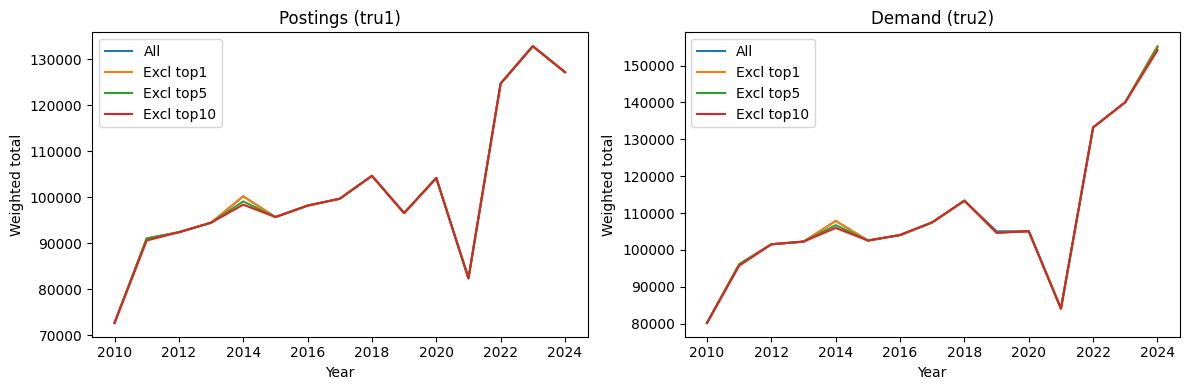

Saved plot to /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase0_qc/visuals/yearly_totals_excluding_topk.png
                                   adve_iden_sjob  \
6770   sjmm_suf-2-01-2011-03-01388-0-000002717-01   
19386  sjmm_suf-2-02-2014-03-02349-0-000002242-01   
19387  sjmm_suf-2-02-2014-03-02349-0-000002243-01   
19389  sjmm_suf-2-02-2014-03-02385-0-000003160-01   
19390  sjmm_suf-2-02-2014-03-02385-0-000003161-01   
19391  sjmm_suf-2-02-2014-03-02385-0-000003163-01   
37437  sjmm_suf-2-02-2019-03-01105-0-000004126-01   
56400  sjmm_suf-3-01-2024-03-09001-1-055501046-00   
56840  sjmm_suf-3-01-2024-03-09010-1-055772365-00   
56879  sjmm_suf-3-01-2024-03-09001-1-055753376-00   

                                adve_iden_adve  adve_time_year  \
6770   sjmm_suf-2-01-2011-03-01388-0-000002717            2011   
19386  sjmm_suf-2-02-2014-03-02349-0-000002242            2014   
19387  sjmm_suf-2-02-2014-03-02349-0-000002243            2014   
19389  sjmm_suf-

In [71]:
# Outlier analysis: exclude top-k ads by tru2
import matplotlib.pyplot as plt

OUT_DIR = ROOT / "Results Datasets" / "analysis" / "phase0_qc"
OUT_DIR_TABLES = OUT_DIR / "tables"
OUT_DIR_VIS = OUT_DIR / "visuals"
for d in [OUT_DIR, OUT_DIR_TABLES, OUT_DIR_VIS]:
    d.mkdir(parents=True, exist_ok=True)

# Identify top ads by tru2
sorted_ids = df.sort_values("srvy_wght_tru2", ascending=False)["adve_iden_sjob"]
top1_ids = set(sorted_ids.head(1))
top5_ids = set(sorted_ids.head(5))
top10_ids = set(sorted_ids.head(10))

def yearly_excl(exclude_ids):
    g = df[~df["adve_iden_sjob"].isin(exclude_ids)].groupby("adve_time_year").agg(
        postings_w=("srvy_wght_tru1","sum"),
        demand_w=("srvy_wght_tru2","sum"),
    ).reset_index().rename(columns={"adve_time_year":"year"})
    return g

base = yearly.rename(columns={"postings_w":"base_post_w", "demand_w":"base_dem_w"})
y1 = yearly_excl(top1_ids).rename(columns={"postings_w":"excl1_post_w", "demand_w":"excl1_dem_w"})
y5 = yearly_excl(top5_ids).rename(columns={"postings_w":"excl5_post_w", "demand_w":"excl5_dem_w"})
y10 = yearly_excl(top10_ids).rename(columns={"postings_w":"excl10_post_w", "demand_w":"excl10_dem_w"})

merged_year = base.merge(y1, on="year").merge(y5, on="year").merge(y10, on="year")

# Plot comparisons
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].plot(merged_year['year'], merged_year['base_post_w'], label='All')
axes[0].plot(merged_year['year'], merged_year['excl1_post_w'], label='Excl top1')
axes[0].plot(merged_year['year'], merged_year['excl5_post_w'], label='Excl top5')
axes[0].plot(merged_year['year'], merged_year['excl10_post_w'], label='Excl top10')
axes[0].set_title('Postings (tru1)')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Weighted total')
axes[0].legend()

axes[1].plot(merged_year['year'], merged_year['base_dem_w'], label='All')
axes[1].plot(merged_year['year'], merged_year['excl1_dem_w'], label='Excl top1')
axes[1].plot(merged_year['year'], merged_year['excl5_dem_w'], label='Excl top5')
axes[1].plot(merged_year['year'], merged_year['excl10_dem_w'], label='Excl top10')
axes[1].set_title('Demand (tru2)')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Weighted total')
axes[1].legend()

plt.tight_layout()
plot_path = OUT_DIR_VIS / 'yearly_totals_excluding_topk.png'
plt.savefig(plot_path, dpi=150)
plt.show()
print('Saved plot to', plot_path)

# Table of top outliers
cols = [
    'adve_iden_sjob','adve_iden_adve','adve_time_year',
    'srvy_wght_tru1','srvy_wght_tru2','adve_empl_nrec',
    'ai_requirement','occupation_exposure','industry_exposure_weighted',
    'occu_titl_adve','adve_chan_gene','adve_lang_lang'
]
for c in cols:
    if c not in df.columns:
        cols.remove(c)

top_outliers = df[df['adve_iden_sjob'].isin(top10_ids)].copy()
if 'srvy_wght_tru1' in top_outliers and 'srvy_wght_tru2' in top_outliers:
    top_outliers['tru2_tru1_ratio'] = top_outliers['srvy_wght_tru2'] / top_outliers['srvy_wght_tru1']

if cols:
    top_outliers = top_outliers[cols + (["tru2_tru1_ratio"] if 'tru2_tru1_ratio' in top_outliers else [])]
print(top_outliers)

# Save table
outlier_path = OUT_DIR_TABLES / 'qc_top_outliers.csv'
top_outliers.to_csv(outlier_path, index=False)
print('Saved outlier table to', outlier_path)


In [72]:
summary_items = {}
summary_items["n_rows"] = len(df)
summary_items["year_min"] = int(df["adve_time_year"].min())
summary_items["year_max"] = int(df["adve_time_year"].max())

# AI labels
label_counts = df["ai_requirement"].value_counts(dropna=False)
summary_items["ai_counts"] = label_counts.to_dict()
all_tot = df[["srvy_wght_tru1","srvy_wght_tru2"]].sum()
strict = df[df["ai_requirement"] == "True"]
lenient = df[df["ai_requirement"].isin(["True","Maybe"])].copy()
strict_tot = strict[["srvy_wght_tru1","srvy_wght_tru2"]].sum()
lenient_tot = lenient[["srvy_wght_tru1","srvy_wght_tru2"]].sum()
summary_items["ai_strict_post_share"] = float(strict_tot["srvy_wght_tru1"] / all_tot["srvy_wght_tru1"])
summary_items["ai_strict_dem_share"] = float(strict_tot["srvy_wght_tru2"] / all_tot["srvy_wght_tru2"])
summary_items["ai_lenient_post_share"] = float(lenient_tot["srvy_wght_tru1"] / all_tot["srvy_wght_tru1"])
summary_items["ai_lenient_dem_share"] = float(lenient_tot["srvy_wght_tru2"] / all_tot["srvy_wght_tru2"])

# Exposure coverage (overall, weighted miss share)
for col in ["occupation_exposure", "industry_exposure_weighted"]:
    miss = df[col].isna()
    summary_items[f"{col}_miss_pct"] = float(miss.mean()*100)
    summary_items[f"{col}_miss_tru2_share"] = float(df.loc[miss, "srvy_wght_tru2"].sum() / all_tot["srvy_wght_tru2"])

# Region unknown share (from earlier calc)
if 'region_unknown' in globals():
    summary_items['region_unknown'] = region_unknown.to_dict(orient='records')

# Weight quantiles
for wcol in ["srvy_wght_tru1", "srvy_wght_tru2"]:
    q = df[wcol].quantile([0.5,0.9,0.95,0.99]).to_dict()
    summary_items[f"{wcol}_quantiles"] = q
    summary_items[f"{wcol}_max"] = float(df[wcol].max())

# Duplicates
for col in ["adve_iden_sjob", "adve_iden_adve"]:
    if col in df.columns:
        summary_items[f"{col}_duplicates"] = int(df[col].duplicated().sum())

summary_items


{'n_rows': 59794,
 'year_min': 2010,
 'year_max': 2024,
 'ai_counts': {'False': 56352, 'Maybe': 2961, 'True': 426, <NA>: 55},
 'ai_strict_post_share': 0.0058030282944299015,
 'ai_strict_dem_share': 0.005933004611537612,
 'ai_lenient_post_share': 0.05622499528600471,
 'ai_lenient_dem_share': 0.054500432633192264,
 'occupation_exposure_miss_pct': 8.447335853095627,
 'occupation_exposure_miss_tru2_share': 0.0816103607635585,
 'industry_exposure_weighted_miss_pct': 16.095260394019466,
 'industry_exposure_weighted_miss_tru2_share': 0.13652542777527307,
 'region_unknown': [{'column': 'loca_regi_kant',
   'unknown_count': 3380,
   'unknown_pct': 5.652741077700104,
   'unknown_tru2_share': 0.060835489601052714,
   'clean_used': True},
  {'column': 'loca_regi_nuts',
   'unknown_count': 3380,
   'unknown_pct': 5.652741077700104,
   'unknown_tru2_share': 0.060835489601052714,
   'clean_used': True}],
 'srvy_wght_tru1_quantiles': {0.5: 16.2857,
  0.9: 43.8,
  0.95: 71.7875,
  0.99: 215.66204499999